In [1]:
# Imports 

import findspark
findspark.init()
from pyspark.sql import SparkSession
from pyspark.sql.functions import*
from pyspark.sql.types import*

#from pyspark.sql.types import StructType,StructField, StringType, IntegerType,BooleanType,DoubleType

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import requests
import seaborn as sns


## Laoding Data and creating Spark DataFrames

In [2]:
spark = SparkSession.builder.master("local[*]").appName("Credit Cards").getOrCreate()

Using Spark's default log4j profile: org/apache/spark/log4j-defaults.properties
Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
23/02/27 17:11:25 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


In [3]:
df_branch = spark.read.json('data/cdw_sapp_branch.json')  
df_credit = spark.read.json('data/cdw_sapp_credit.json') 
df_customers = spark.read.json('data/cdw_sapp_custmer.json')

In [4]:
type(df_branch)

pyspark.sql.dataframe.DataFrame

## Cleaning DataFrame according to mapping doc

In [5]:
df_branch.show(5)

+-----------------+-----------+------------+------------+------------+-----------------+----------+--------------------+
|      BRANCH_CITY|BRANCH_CODE| BRANCH_NAME|BRANCH_PHONE|BRANCH_STATE|    BRANCH_STREET|BRANCH_ZIP|        LAST_UPDATED|
+-----------------+-----------+------------+------------+------------+-----------------+----------+--------------------+
|        Lakeville|          1|Example Bank|  1234565276|          MN|     Bridle Court|     55044|2018-04-18T16:51:...|
|          Huntley|          2|Example Bank|  1234618993|          IL|Washington Street|     60142|2018-04-18T16:51:...|
|SouthRichmondHill|          3|Example Bank|  1234985926|          NY|    Warren Street|     11419|2018-04-18T16:51:...|
|       Middleburg|          4|Example Bank|  1234663064|          FL| Cleveland Street|     32068|2018-04-18T16:51:...|
|    KingOfPrussia|          5|Example Bank|  1234849701|          PA|      14th Street|     19406|2018-04-18T16:51:...|
+-----------------+-----------+-

In [6]:
df_branch.columns

['BRANCH_CITY',
 'BRANCH_CODE',
 'BRANCH_NAME',
 'BRANCH_PHONE',
 'BRANCH_STATE',
 'BRANCH_STREET',
 'BRANCH_ZIP',
 'LAST_UPDATED']

In [7]:
df_branch.select('BRANCH_PHONE').show(5)

+------------+
|BRANCH_PHONE|
+------------+
|  1234565276|
|  1234618993|
|  1234985926|
|  1234663064|
|  1234849701|
+------------+
only showing top 5 rows



In [8]:
#transforming the branch df
df_branch = df_branch.withColumn('BRANCH_PHONE', concat(lit('('), col('BRANCH_PHONE')[0:3], lit(')'), 
                                col('BRANCH_PHONE')[4:3], lit('-'), col('BRANCH_PHONE')[7:9]))

df_branch.select('BRANCH_PHONE').show(5)

+-------------+
| BRANCH_PHONE|
+-------------+
|(123)456-5276|
|(123)461-8993|
|(123)498-5926|
|(123)466-3064|
|(123)484-9701|
+-------------+
only showing top 5 rows



In [9]:
#checking for nulls in zip code
df_branch.filter(df_branch.BRANCH_ZIP.isNull()).show()

+-----------+-----------+-----------+------------+------------+-------------+----------+------------+
|BRANCH_CITY|BRANCH_CODE|BRANCH_NAME|BRANCH_PHONE|BRANCH_STATE|BRANCH_STREET|BRANCH_ZIP|LAST_UPDATED|
+-----------+-----------+-----------+------------+------------+-------------+----------+------------+
+-----------+-----------+-----------+------------+------------+-------------+----------+------------+



In [10]:
#there are no nulls in branch zip
print(df_branch.count())
print(df_branch.filter(col('BRANCH_ZIP').isNull()).count())
print(df_branch.filter(col('BRANCH_ZIP').isNotNull()).count())

115
0
115


### Keep??

In [11]:
df_branch.na.fill(value=99999,subset=['BRANCH_ZIP'])


DataFrame[BRANCH_CITY: string, BRANCH_CODE: bigint, BRANCH_NAME: string, BRANCH_PHONE: string, BRANCH_STATE: string, BRANCH_STREET: string, BRANCH_ZIP: bigint, LAST_UPDATED: string]

In [12]:
df_credit.show(5)

+-----------+----------------+---------+---+-----+--------------+----------------+-----------------+----+
|BRANCH_CODE|  CREDIT_CARD_NO| CUST_SSN|DAY|MONTH|TRANSACTION_ID|TRANSACTION_TYPE|TRANSACTION_VALUE|YEAR|
+-----------+----------------+---------+---+-----+--------------+----------------+-----------------+----+
|        114|4210653349028689|123459988| 14|    2|             1|       Education|             78.9|2018|
|         35|4210653349028689|123459988| 20|    3|             2|   Entertainment|            14.24|2018|
|        160|4210653349028689|123459988|  8|    7|             3|         Grocery|             56.7|2018|
|        114|4210653349028689|123459988| 19|    4|             4|   Entertainment|            59.73|2018|
|         93|4210653349028689|123459988| 10|   10|             5|             Gas|             3.59|2018|
+-----------+----------------+---------+---+-----+--------------+----------------+-----------------+----+
only showing top 5 rows



In [13]:
df_credit.columns

['BRANCH_CODE',
 'CREDIT_CARD_NO',
 'CUST_SSN',
 'DAY',
 'MONTH',
 'TRANSACTION_ID',
 'TRANSACTION_TYPE',
 'TRANSACTION_VALUE',
 'YEAR']

In [14]:
df_credit = df_credit.withColumnRenamed('CREDIT_CARD_NO', 'CUST_CC_NO')
df_credit = df_credit.withColumn('TIMEID', expr('make_date(YEAR, MONTH, DAY)'))
df_credit.show(5)

+-----------+----------------+---------+---+-----+--------------+----------------+-----------------+----+----------+
|BRANCH_CODE|      CUST_CC_NO| CUST_SSN|DAY|MONTH|TRANSACTION_ID|TRANSACTION_TYPE|TRANSACTION_VALUE|YEAR|    TIMEID|
+-----------+----------------+---------+---+-----+--------------+----------------+-----------------+----+----------+
|        114|4210653349028689|123459988| 14|    2|             1|       Education|             78.9|2018|2018-02-14|
|         35|4210653349028689|123459988| 20|    3|             2|   Entertainment|            14.24|2018|2018-03-20|
|        160|4210653349028689|123459988|  8|    7|             3|         Grocery|             56.7|2018|2018-07-08|
|        114|4210653349028689|123459988| 19|    4|             4|   Entertainment|            59.73|2018|2018-04-19|
|         93|4210653349028689|123459988| 10|   10|             5|             Gas|             3.59|2018|2018-10-10|
+-----------+----------------+---------+---+-----+--------------

In [15]:
#df_credit = df_credit.drop('DAY', 'MONTH', 'YEAR')
#df_credit.columns

### Clarify customer phone conversion - only have 7 digits

In [16]:
df_customers.select('CUST_PHONE').show(5)

+----------+
|CUST_PHONE|
+----------+
|   1237818|
|   1238933|
|   1243018|
|   1243215|
|   1242074|
+----------+
only showing top 5 rows



In [17]:
df_customers.show(5)

+------+----------------+------------+-------------+-------------------+----------+----------+--------+----------+---------+--------------------+-----------+---------+-----------------+
|APT_NO|  CREDIT_CARD_NO|   CUST_CITY| CUST_COUNTRY|         CUST_EMAIL|CUST_PHONE|CUST_STATE|CUST_ZIP|FIRST_NAME|LAST_NAME|        LAST_UPDATED|MIDDLE_NAME|      SSN|      STREET_NAME|
+------+----------------+------------+-------------+-------------------+----------+----------+--------+----------+---------+--------------------+-----------+---------+-----------------+
|   656|4210653310061055|     Natchez|United States|AHooper@example.com|   1237818|        MS|   39120|      Alec|   Hooper|2018-04-21T12:49:...|         Wm|123456100|Main Street North|
|   829|4210653310102868|Wethersfield|United States|EHolman@example.com|   1238933|        CT|   06109|      Etta|   Holman|2018-04-21T12:49:...|    Brendan|123453023|    Redwood Drive|
|   683|4210653310116272|     Huntley|United States|WDunham@example.co

In [18]:
df_customers.columns

['APT_NO',
 'CREDIT_CARD_NO',
 'CUST_CITY',
 'CUST_COUNTRY',
 'CUST_EMAIL',
 'CUST_PHONE',
 'CUST_STATE',
 'CUST_ZIP',
 'FIRST_NAME',
 'LAST_NAME',
 'LAST_UPDATED',
 'MIDDLE_NAME',
 'SSN',
 'STREET_NAME']

In [19]:
#transforming the customer df
df_customers = df_customers.withColumn('FIRST_NAME', initcap(df_customers['FIRST_NAME']))
df_customers = df_customers.withColumn('MIDDLE_NAME', lower(df_customers['MIDDLE_NAME']))
df_customers = df_customers.withColumn('LAST_NAME', initcap(df_customers['LAST_NAME']))
df_customers = df_customers.withColumnRenamed('CREDIT_CARD_NO', 'Credit_card_no')
df_customers = df_customers.withColumn('FULL_STREET_ADDRESS', concat(col('APT_NO'),lit(','),col('STREET_NAME')))
df_customers.show(5)


+------+----------------+------------+-------------+-------------------+----------+----------+--------+----------+---------+--------------------+-----------+---------+-----------------+--------------------+
|APT_NO|  Credit_card_no|   CUST_CITY| CUST_COUNTRY|         CUST_EMAIL|CUST_PHONE|CUST_STATE|CUST_ZIP|FIRST_NAME|LAST_NAME|        LAST_UPDATED|MIDDLE_NAME|      SSN|      STREET_NAME| FULL_STREET_ADDRESS|
+------+----------------+------------+-------------+-------------------+----------+----------+--------+----------+---------+--------------------+-----------+---------+-----------------+--------------------+
|   656|4210653310061055|     Natchez|United States|AHooper@example.com|   1237818|        MS|   39120|      Alec|   Hooper|2018-04-21T12:49:...|         wm|123456100|Main Street North|656,Main Street N...|
|   829|4210653310102868|Wethersfield|United States|EHolman@example.com|   1238933|        CT|   06109|      Etta|   Holman|2018-04-21T12:49:...|    brendan|123453023|    R

In [20]:
#dropping address and apt cols
df_customers = df_customers.drop('APT_NO', 'STREET_NAME')
df_customers.columns

['Credit_card_no',
 'CUST_CITY',
 'CUST_COUNTRY',
 'CUST_EMAIL',
 'CUST_PHONE',
 'CUST_STATE',
 'CUST_ZIP',
 'FIRST_NAME',
 'LAST_NAME',
 'LAST_UPDATED',
 'MIDDLE_NAME',
 'SSN',
 'FULL_STREET_ADDRESS']

In [21]:
print(df_branch.show())
print(df_credit.show())
print(df_customers.show())

+-----------------+-----------+------------+-------------+------------+-------------------+----------+--------------------+
|      BRANCH_CITY|BRANCH_CODE| BRANCH_NAME| BRANCH_PHONE|BRANCH_STATE|      BRANCH_STREET|BRANCH_ZIP|        LAST_UPDATED|
+-----------------+-----------+------------+-------------+------------+-------------------+----------+--------------------+
|        Lakeville|          1|Example Bank|(123)456-5276|          MN|       Bridle Court|     55044|2018-04-18T16:51:...|
|          Huntley|          2|Example Bank|(123)461-8993|          IL|  Washington Street|     60142|2018-04-18T16:51:...|
|SouthRichmondHill|          3|Example Bank|(123)498-5926|          NY|      Warren Street|     11419|2018-04-18T16:51:...|
|       Middleburg|          4|Example Bank|(123)466-3064|          FL|   Cleveland Street|     32068|2018-04-18T16:51:...|
|    KingOfPrussia|          5|Example Bank|(123)484-9701|          PA|        14th Street|     19406|2018-04-18T16:51:...|
|       

Once PySpark reads data from JSON files, and then utilizes Python, PySpark, and Python modules to load data into RDBMS(SQL), perform the following:
 
Create a Database in SQL(MariaDB), named “creditcard_capstone.”
Create a Python and Pyspark Program to load/write the “Credit Card System Data” into RDBMS(creditcard_capstone).
Tables should be created by the following names in RDBMS:
CDW_SAPP_BRANCH
CDW_SAPP_CREDIT_CARD
CDW_SAPP_CUSTOMER 

In [22]:
df_branch.write.format("jdbc") \
  .mode("append") \
  .option("url", "jdbc:mysql://localhost:3306/creditcard_capstone") \
  .option("dbtable", "creditcard_capstone.CDW_SAPP_BRANCH") \
  .option("user", "root") \
  .option("password", "pass1234") \
  .save()

Py4JJavaError: An error occurred while calling o118.save.
: java.sql.SQLException: No suitable driver
	at java.sql/java.sql.DriverManager.getDriver(DriverManager.java:298)
	at org.apache.spark.sql.execution.datasources.jdbc.JDBCOptions.$anonfun$driverClass$2(JDBCOptions.scala:107)
	at scala.Option.getOrElse(Option.scala:189)
	at org.apache.spark.sql.execution.datasources.jdbc.JDBCOptions.<init>(JDBCOptions.scala:107)
	at org.apache.spark.sql.execution.datasources.jdbc.JdbcOptionsInWrite.<init>(JDBCOptions.scala:218)
	at org.apache.spark.sql.execution.datasources.jdbc.JdbcOptionsInWrite.<init>(JDBCOptions.scala:222)
	at org.apache.spark.sql.execution.datasources.jdbc.JdbcRelationProvider.createRelation(JdbcRelationProvider.scala:46)
	at org.apache.spark.sql.execution.datasources.SaveIntoDataSourceCommand.run(SaveIntoDataSourceCommand.scala:45)
	at org.apache.spark.sql.execution.command.ExecutedCommandExec.sideEffectResult$lzycompute(commands.scala:75)
	at org.apache.spark.sql.execution.command.ExecutedCommandExec.sideEffectResult(commands.scala:73)
	at org.apache.spark.sql.execution.command.ExecutedCommandExec.executeCollect(commands.scala:84)
	at org.apache.spark.sql.execution.QueryExecution$$anonfun$eagerlyExecuteCommands$1.$anonfun$applyOrElse$1(QueryExecution.scala:110)
	at org.apache.spark.sql.execution.SQLExecution$.$anonfun$withNewExecutionId$5(SQLExecution.scala:103)
	at org.apache.spark.sql.execution.SQLExecution$.withSQLConfPropagated(SQLExecution.scala:163)
	at org.apache.spark.sql.execution.SQLExecution$.$anonfun$withNewExecutionId$1(SQLExecution.scala:90)
	at org.apache.spark.sql.SparkSession.withActive(SparkSession.scala:775)
	at org.apache.spark.sql.execution.SQLExecution$.withNewExecutionId(SQLExecution.scala:64)
	at org.apache.spark.sql.execution.QueryExecution$$anonfun$eagerlyExecuteCommands$1.applyOrElse(QueryExecution.scala:110)
	at org.apache.spark.sql.execution.QueryExecution$$anonfun$eagerlyExecuteCommands$1.applyOrElse(QueryExecution.scala:106)
	at org.apache.spark.sql.catalyst.trees.TreeNode.$anonfun$transformDownWithPruning$1(TreeNode.scala:481)
	at org.apache.spark.sql.catalyst.trees.CurrentOrigin$.withOrigin(TreeNode.scala:82)
	at org.apache.spark.sql.catalyst.trees.TreeNode.transformDownWithPruning(TreeNode.scala:481)
	at org.apache.spark.sql.catalyst.plans.logical.LogicalPlan.org$apache$spark$sql$catalyst$plans$logical$AnalysisHelper$$super$transformDownWithPruning(LogicalPlan.scala:30)
	at org.apache.spark.sql.catalyst.plans.logical.AnalysisHelper.transformDownWithPruning(AnalysisHelper.scala:267)
	at org.apache.spark.sql.catalyst.plans.logical.AnalysisHelper.transformDownWithPruning$(AnalysisHelper.scala:263)
	at org.apache.spark.sql.catalyst.plans.logical.LogicalPlan.transformDownWithPruning(LogicalPlan.scala:30)
	at org.apache.spark.sql.catalyst.plans.logical.LogicalPlan.transformDownWithPruning(LogicalPlan.scala:30)
	at org.apache.spark.sql.catalyst.trees.TreeNode.transformDown(TreeNode.scala:457)
	at org.apache.spark.sql.execution.QueryExecution.eagerlyExecuteCommands(QueryExecution.scala:106)
	at org.apache.spark.sql.execution.QueryExecution.commandExecuted$lzycompute(QueryExecution.scala:93)
	at org.apache.spark.sql.execution.QueryExecution.commandExecuted(QueryExecution.scala:91)
	at org.apache.spark.sql.execution.QueryExecution.assertCommandExecuted(QueryExecution.scala:128)
	at org.apache.spark.sql.DataFrameWriter.runCommand(DataFrameWriter.scala:848)
	at org.apache.spark.sql.DataFrameWriter.saveToV1Source(DataFrameWriter.scala:382)
	at org.apache.spark.sql.DataFrameWriter.saveInternal(DataFrameWriter.scala:355)
	at org.apache.spark.sql.DataFrameWriter.save(DataFrameWriter.scala:247)
	at java.base/jdk.internal.reflect.NativeMethodAccessorImpl.invoke0(Native Method)
	at java.base/jdk.internal.reflect.NativeMethodAccessorImpl.invoke(NativeMethodAccessorImpl.java:62)
	at java.base/jdk.internal.reflect.DelegatingMethodAccessorImpl.invoke(DelegatingMethodAccessorImpl.java:43)
	at java.base/java.lang.reflect.Method.invoke(Method.java:566)
	at py4j.reflection.MethodInvoker.invoke(MethodInvoker.java:244)
	at py4j.reflection.ReflectionEngine.invoke(ReflectionEngine.java:357)
	at py4j.Gateway.invoke(Gateway.java:282)
	at py4j.commands.AbstractCommand.invokeMethod(AbstractCommand.java:132)
	at py4j.commands.CallCommand.execute(CallCommand.java:79)
	at py4j.ClientServerConnection.waitForCommands(ClientServerConnection.java:182)
	at py4j.ClientServerConnection.run(ClientServerConnection.java:106)
	at java.base/java.lang.Thread.run(Thread.java:829)


In [ ]:
df_credit.write.format("jdbc") \
  .mode("append") \
  .option("url", "jdbc:mysql://localhost:3306/creditcard_capstone") \
  .option("dbtable", "creditcard_capstone.CDW_SAPP_CREDIT_CARD") \
  .option("user", "root") \
  .option("password", "pass1234") \
  .save()

In [ ]:
df_customers.write.format("jdbc") \
  .mode("append") \
  .option("url", "jdbc:mysql://localhost:3306/creditcard_capstone") \
  .option("dbtable", "creditcard_capstone.CDW_SAPP_CUSTOMER") \
  .option("user", "root") \
  .option("password", "pass1234") \
  .save()

In [ ]:
df_branch.write.format("jdbc") \
  .mode("append") \
  .option("url", "jdbc:mysql://localhost:3306/creditcard_capstone") \
  .option("dbtable", "creditcard_capstone.CDW_SAPP_BRANCH") \
  .option("user", "root") \
  .option("password", "pass1234") \
  .save()

df_credit.write.format("jdbc") \
  .mode("append") \
  .option("url", "jdbc:mysql://localhost:3306/creditcard_capstone") \
  .option("dbtable", "creditcard_capstone.CDW_SAPP_CREDIT_CARD") \
  .option("user", "root") \
  .option("password", "pass1234") \
  .save()

df_customers.write.format("jdbc") \
  .mode("append") \
  .option("url", "jdbc:mysql://localhost:3306/creditcard_capstone") \
  .option("dbtable", "creditcard_capstone.CDW_SAPP_CUSTOMER ") \
  .option("user", "root") \
  .option("password", "pass1234") \
  .save()

1)    Used to display the transactions made by customers living in a given zip code for a given month and year. Order by day in descending order.
2)    Used to display the number and total values of transactions for a given type.
3)    Used to display the number and total values of transactions for branches in a given state.

##format
-- Create or replace view for `experienced_employee` with comments.
> CREATE OR REPLACE VIEW experienced_employee
    (id COMMENT 'Unique identification number', Name)
    COMMENT 'View for experienced employees'
    AS SELECT id, name
         FROM all_employee
        WHERE working_years > 5;

-- Create a temporary view `subscribed_movies`.
> CREATE TEMPORARY VIEW subscribed_movies
    AS SELECT mo.member_id, mb.full_name, mo.movie_title
         FROM movies AS mo
         INNER JOIN members AS mb
            ON mo.member_id = mb.id;

https://docs.databricks.com/sql/language-manual/sql-ref-syntax-ddl-create-view.html


### Question global v not global temp_view

Let’s create a temporary view on top of the DataFrame object by using df.createOrReplaceTempView(). Spark SQL temporary views are session-scoped and will not be available if the session that creates it terminates. The following examples create a Person table.


// Create Temporary View/Table 
df.createOrReplaceTempView("Person")-  temporary view that is not shared among all sessions and keep alive until the Spark application terminates, you can create a global temporary view using
df.createGlobalTempView('Person'-  temporary view that is shared among all sessions and keep alive until the Spark application terminates, you can create a global temporary view using




https://sparkbyexamples.com/spark/spark-createorreplacetempview-explained/

// Run SQL Query
spark.sql("select firstname, lastname from Person").show()

In [22]:
df_branch.createOrReplaceTempView("branch")
df_credit.createOrReplaceTempView("credit")
df_customers.createOrReplaceTempView("customers")

can also convert to DF and join df together.

then write functions

In [ ]:
df_branch_pd = df_branch.toPandas()
df_credit_pd = df_credit.toPandas()
df_customers_pd = df_customers.toPandas()


1) Used to check the existing account details of a customer.
2) Used to modify the existing account details of a customer.
3) Used to generate a monthly bill for a credit card number for a given month and year.
4) Used to display the transactions made by a customer between two dates. Order by year, month, and day in descending order.


In [ ]:
df_customers_pd.columns

In [ ]:
df_credit_pd.columns

In [ ]:
trans_df = pd.merge(df_credit_pd, df_customers_pd, how='inner', left_on = 'CUST_SSN', right_on = 'SSN')

## def transactions(zipcode, month, year):
    sel = "SELECT customer.CUST_ZIP, credit.DAY, credit.MONTH, credit.YEAR, credit.TRANSACTION_TYPE, credit.TRANSACTION_VALUE"
    frm = " FROM credit, customer"
    where = f" WHERE credit.YEAR = {str(Year)} AND credit.MONTH = {str(Month)} AND customer.CUST_ZIP = {str(Zipcode)}"
    ordr = " ORDER BY credit.DAY DESC" # Order by descending 

    sqlCredit = spark.sql(sel + frm + where + ordr)
    sqlCredit.show(10)

customer_transactions(8, 2018, 39120)



def get_credit_card_transaction_byzip_monthyear(zipcode, month, year):
    dateid = year + month 
    df_credit.join(df_cust, df_credit.CUST_SSN == df_cust.SSN, 'inner'). \
        select(df_credit.TRANSACTION_ID, df_credit.CUST_SSN, df_cust.CUST_ZIP, df_credit.TIMEID, df_credit.TRANSACTION_TYPE, df_credit.TRANSACTION_VALUE). \
        filter((df_cust.CUST_ZIP==zipcode) & (df_credit.TIMEID.like(dateid + '%'))). \
        sort(df_credit.TIMEID.desc()).show()

Find and plot which transaction type has a high rate of transactions.

Note: Take a screenshot of the graphs. 
Find and plot which state has a high number of customers.

Note: Take a screenshot of the graphs. 
Find and plot the sum of all transactions for each customer, and which customer has the highest transaction amount.
hint(use CUST_SSN).

Note: Take a screenshot of the graphs. 



## 3

In [23]:
print(df_branch.show(5))
print(df_credit.show(5))
print(df_customers.show(5))

+-----------------+-----------+------------+-------------+------------+-----------------+----------+--------------------+
|      BRANCH_CITY|BRANCH_CODE| BRANCH_NAME| BRANCH_PHONE|BRANCH_STATE|    BRANCH_STREET|BRANCH_ZIP|        LAST_UPDATED|
+-----------------+-----------+------------+-------------+------------+-----------------+----------+--------------------+
|        Lakeville|          1|Example Bank|(123)456-5276|          MN|     Bridle Court|     55044|2018-04-18T16:51:...|
|          Huntley|          2|Example Bank|(123)461-8993|          IL|Washington Street|     60142|2018-04-18T16:51:...|
|SouthRichmondHill|          3|Example Bank|(123)498-5926|          NY|    Warren Street|     11419|2018-04-18T16:51:...|
|       Middleburg|          4|Example Bank|(123)466-3064|          FL| Cleveland Street|     32068|2018-04-18T16:51:...|
|    KingOfPrussia|          5|Example Bank|(123)484-9701|          PA|      14th Street|     19406|2018-04-18T16:51:...|
+-----------------+-----

In [24]:
pd_credit = df_credit.toPandas()
pd_credit

,BRANCH_CODE,CUST_CC_NO,CUST_SSN,DAY,MONTH,TRANSACTION_ID,TRANSACTION_TYPE,TRANSACTION_VALUE,YEAR,TIMEID
0,114,4210653349028689,123459988,14,2,1,Education,78.90,2018,2018-02-14
1,35,4210653349028689,123459988,20,3,2,Entertainment,14.24,2018,2018-03-20
2,160,4210653349028689,123459988,8,7,3,Grocery,56.70,2018,2018-07-08
3,114,4210653349028689,123459988,19,4,4,Entertainment,59.73,2018,2018-04-19
4,93,4210653349028689,123459988,10,10,5,Gas,3.59,2018,2018-10-10
...,...,...,...,...,...,...,...,...,...,...
46689,49,4210653344660822,123451007,12,9,46690,Gas,66.20,2018,2018-09-12
46690,168,4210653344660822,123451007,5,2,46691,Grocery,100.13,2018,2018-02-05
46691,104,4210653344660822,123451007,16,12,46692,Test,35.83,2018,2018-12-16
46692,32,4210653344660822,123451007,15,1,46693,Entertainment,90.99,2018,2018-01-15


In [25]:
#numbers are right but overwriting??
pd_credit.groupby(['TRANSACTION_TYPE']).count()

,BRANCH_CODE,CUST_CC_NO,CUST_SSN,DAY,MONTH,TRANSACTION_ID,TRANSACTION_VALUE,YEAR,TIMEID
TRANSACTION_TYPE,,,,,,,,,
Bills,6861,6861,6861,6861,6861,6861,6861,6861,6861
Education,6638,6638,6638,6638,6638,6638,6638,6638,6638
Entertainment,6635,6635,6635,6635,6635,6635,6635,6635,6635
Gas,6605,6605,6605,6605,6605,6605,6605,6605,6605
Grocery,6549,6549,6549,6549,6549,6549,6549,6549,6549
Healthcare,6723,6723,6723,6723,6723,6723,6723,6723,6723
Test,6683,6683,6683,6683,6683,6683,6683,6683,6683


In [27]:
#df2 = df.groupby(['Courses'])['Courses'].count()
transaction_type = pd_credit.groupby(['TRANSACTION_TYPE'])['TRANSACTION_TYPE'].count()
transaction_type

TRANSACTION_TYPE
Bills            6861
Education        6638
Entertainment    6635
Gas              6605
Grocery          6549
Healthcare       6723
Test             6683
Name: TRANSACTION_TYPE, dtype: int64

In [58]:
type(transaction_names)

pandas.core.series.Series

In [29]:
transaction_names = pd_credit.TRANSACTION_TYPE.value_counts()
transaction_names

Bills            6861
Healthcare       6723
Test             6683
Education        6638
Entertainment    6635
Gas              6605
Grocery          6549
Name: TRANSACTION_TYPE, dtype: int64

In [30]:
transaction_names = pd_credit.TRANSACTION_TYPE.value_counts()
types_df = transaction_names.reset_index()
types_df.columns = ['categories', 'frequency']

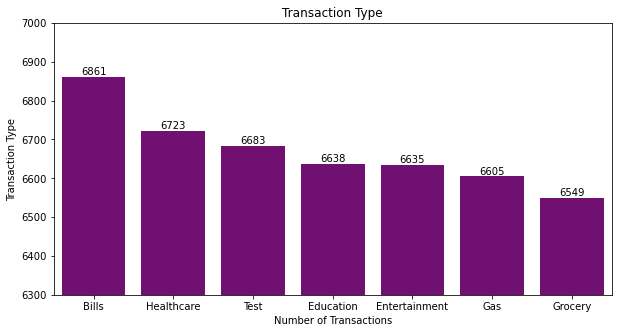

In [31]:
fig, ax = plt.subplots(figsize=(10, 5))
ax = sns.barplot(x='categories', y='frequency', data=types_df, color='purple')
plt.title('Transaction Type')
plt.xlabel('Number of Transactions')
plt.ylabel('Transaction Type')
plt.ylim(6300, 7000)
ax.bar_label(ax.containers[0]);



In [79]:
pip show matplotlib

Name: matplotlib
Version: 3.3.1
Summary: Python plotting package
Home-page: https://matplotlib.org
Author: John D. Hunter, Michael Droettboom
Author-email: matplotlib-users@python.org
License: PSF
Location: /opt/anaconda3/envs/learn-env/lib/python3.8/site-packages
Requires: kiwisolver, python-dateutil, pillow, numpy, certifi, pyparsing, cycler
Required-by: seaborn, fbprophet, arviz
Note: you may need to restart the kernel to use updated packages.


In [32]:
pd_customers = df_customers.toPandas()
pd_customers

,Credit_card_no,CUST_CITY,CUST_COUNTRY,CUST_EMAIL,CUST_PHONE,CUST_STATE,CUST_ZIP,FIRST_NAME,LAST_NAME,LAST_UPDATED,MIDDLE_NAME,SSN,FULL_STREET_ADDRESS
0,4210653310061055,Natchez,United States,AHooper@example.com,1237818,MS,39120,Alec,Hooper,2018-04-21T12:49:02.000-04:00,wm,123456100,"656,Main Street North"
1,4210653310102868,Wethersfield,United States,EHolman@example.com,1238933,CT,06109,Etta,Holman,2018-04-21T12:49:02.000-04:00,brendan,123453023,"829,Redwood Drive"
2,4210653310116272,Huntley,United States,WDunham@example.com,1243018,IL,60142,Wilber,Dunham,2018-04-21T12:49:02.000-04:00,ezequiel,123454487,"683,12th Street East"
3,4210653310195948,NewBerlin,United States,EHardy@example.com,1243215,WI,53151,Eugenio,Hardy,2018-04-21T12:49:02.000-04:00,trina,123459758,"253,Country Club Road"
4,4210653310356919,ElPaso,United States,WAyers@example.com,1242074,TX,79930,Wilfred,Ayers,2018-04-21T12:49:02.000-04:00,may,123454431,"301,Madison Street"
...,...,...,...,...,...,...,...,...,...,...,...,...,...
947,4210653399559239,SiouxCity,United States,FCastle@example.com,1238344,IA,51106,Freida,Castle,2018-04-21T12:49:02.000-04:00,jonah,123451589,"882,Main Street South"
948,4210653399650358,Summerville,United States,FBlock@example.com,1240420,SC,29483,Fern,Block,2018-04-21T12:49:02.000-04:00,aron,123457088,"470,Glenwood Avenue"
949,4210653399732638,Duluth,United States,DPruitt@example.com,1236149,GA,30096,Dylan,Pruitt,2018-04-21T12:49:02.000-04:00,lucas,123453259,"405,Country Lane"
950,4210653399859149,Rowlett,United States,EBeatty@example.com,1236886,TX,75088,Emery,Beatty,2018-04-21T12:49:02.000-04:00,susanna,123454047,"15,8th Street"


In [47]:
states = pd_customers.groupby(['CUST_STATE'])['CUST_STATE'].count()
states

CUST_STATE
AL     5
AR     5
CA    45
CT    14
FL    64
GA    73
IA    21
IL    58
IN    13
KY    17
MA    33
MD    50
MI    44
MN    28
MS    24
MT     9
NC    37
NJ    53
NY    96
OH    44
PA    72
SC    30
TX    33
VA    39
WA    16
WI    29
Name: CUST_STATE, dtype: int64

In [34]:
state_names= pd_customers.CUST_STATE.value_counts()
state_count = state_names.reset_index()
state_count.columns = ['states', 'frequency']
state_count

,states,frequency
0,NY,96
1,GA,73
2,PA,72
3,FL,64
4,IL,58
5,NJ,53
6,MD,50
7,CA,45
8,OH,44
9,MI,44


In [35]:
#limit 8
top_8_states = state_count.nlargest(8, ['frequency'])
top_8_states

,states,frequency
0,NY,96
1,GA,73
2,PA,72
3,FL,64
4,IL,58
5,NJ,53
6,MD,50
7,CA,45


In [50]:
top_8= state_count.sort_values(by=['frequency'], ascending=False).head(8)
top_8

,states,frequency
0,NY,96
1,GA,73
2,PA,72
3,FL,64
4,IL,58
5,NJ,53
6,MD,50
7,CA,45


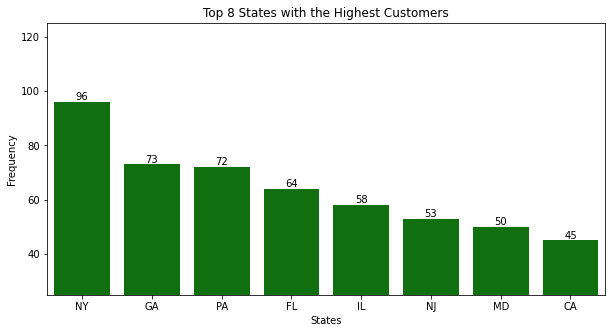

In [52]:
fig, ax = plt.subplots(figsize=(10, 5))
ax = sns.barplot(x='states', y='frequency', data=top_8_states, color='green')
#ax.set_title('Transaction Type')
#ax.set_xlabel('Number of Transactions')
#ax.set_ylabel('Transaction Type')
#ax.set_ylim(6300, 7000)
plt.title('Top 8 States with the Highest Customers')
plt.xlabel('States')
plt.ylabel('Frequency')
plt.ylim(25, 125)
ax.bar_label(ax.containers[0]);

In [53]:
pd_credit

,BRANCH_CODE,CUST_CC_NO,CUST_SSN,DAY,MONTH,TRANSACTION_ID,TRANSACTION_TYPE,TRANSACTION_VALUE,YEAR,TIMEID
0,114,4210653349028689,123459988,14,2,1,Education,78.90,2018,2018-02-14
1,35,4210653349028689,123459988,20,3,2,Entertainment,14.24,2018,2018-03-20
2,160,4210653349028689,123459988,8,7,3,Grocery,56.70,2018,2018-07-08
3,114,4210653349028689,123459988,19,4,4,Entertainment,59.73,2018,2018-04-19
4,93,4210653349028689,123459988,10,10,5,Gas,3.59,2018,2018-10-10
...,...,...,...,...,...,...,...,...,...,...
46689,49,4210653344660822,123451007,12,9,46690,Gas,66.20,2018,2018-09-12
46690,168,4210653344660822,123451007,5,2,46691,Grocery,100.13,2018,2018-02-05
46691,104,4210653344660822,123451007,16,12,46692,Test,35.83,2018,2018-12-16
46692,32,4210653344660822,123451007,15,1,46693,Entertainment,90.99,2018,2018-01-15


In [57]:
customer_transaction = pd_credit.groupby(['CUST_SSN'])['TRANSACTION_VALUE'].sum()
customer_transaction

CUST_SSN
123451007    2037.98
123451012    4025.69
123451037    2122.20
123451041    1085.14
123451068    2810.54
              ...   
123459940      96.27
123459965    2152.70
123459968     964.21
123459978    3091.78
123459988    4760.29
Name: TRANSACTION_VALUE, Length: 952, dtype: float64

In [65]:
individual_cust = customer_transaction.reset_index()
individual_cust.sort_values(by=['TRANSACTION_VALUE'], ascending=False, inplace=True)
individual_cust

,CUST_SSN,TRANSACTION_VALUE
14,123451125,5633.07
177,123452783,5548.14
248,123453486,5476.08
814,123458668,5314.97
599,123456678,5261.03
...,...,...
493,123455652,73.59
238,123453375,73.08
873,123459201,61.67
129,123452345,10.41


In [66]:
top_1_customer = individual_cust.head(1)
top_1_customer

,CUST_SSN,TRANSACTION_VALUE
14,123451125,5633.07


In [67]:
top_15_customers= individual_cust.nlargest(15, ['TRANSACTION_VALUE'])
top_15_customers

,CUST_SSN,TRANSACTION_VALUE
14,123451125,5633.07
177,123452783,5548.14
248,123453486,5476.08
814,123458668,5314.97
599,123456678,5261.03
99,123452026,5241.18
152,123452518,5223.96
414,123454933,5203.08
693,123457547,5149.75
102,123452085,5133.29


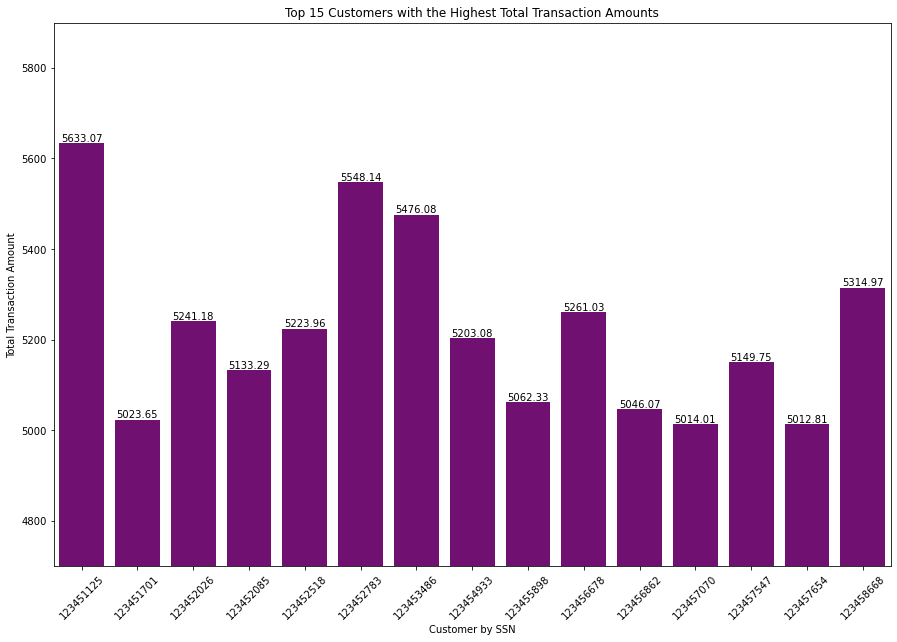

In [70]:

fig, ax = plt.subplots(figsize=(15, 10))
ax = sns.barplot(x='CUST_SSN', y='TRANSACTION_VALUE', data=top_15_customers, color='purple')
#ax.set_title('Transaction Type')
#ax.set_xlabel('Number of Transactions')
#ax.set_ylabel('Transaction Type')
#ax.set_ylim(6300, 7000)
plt.title('Top 15 Customers with the Highest Total Transaction Amounts')
plt.xlabel('Customer by SSN')
plt.ylabel('Total Transaction Amount')
plt.ylim(4700, 5900)
ax.set_xticklabels(ax.get_xticklabels(), rotation=45)
ax.bar_label(ax.containers[0]);

## 4

In [71]:
url = 'https://raw.githubusercontent.com/platformps/LoanDataset/main/loan_data.json'
response = requests.get(url)
data = response.json()
data

[{'Application_ID': 'LP001002',
  'Gender': 'Male',
  'Married': 'No',
  'Dependents': '0',
  'Education': 'Graduate',
  'Self_Employed': 'No',
  'Credit_History': 1,
  'Property_Area': 'Urban',
  'Income': 'medium',
  'Application_Status': 'Y'},
 {'Application_ID': 'LP001003',
  'Gender': 'Male',
  'Married': 'Yes',
  'Dependents': '1',
  'Education': 'Graduate',
  'Self_Employed': 'No',
  'Credit_History': 1,
  'Property_Area': 'Rural',
  'Income': 'medium',
  'Application_Status': 'N'},
 {'Application_ID': 'LP001005',
  'Gender': 'Male',
  'Married': 'Yes',
  'Dependents': '0',
  'Education': 'Graduate',
  'Self_Employed': 'Yes',
  'Credit_History': 1,
  'Property_Area': 'Urban',
  'Income': 'low',
  'Application_Status': 'Y'},
 {'Application_ID': 'LP001006',
  'Gender': 'Male',
  'Married': 'Yes',
  'Dependents': '0',
  'Education': 'Not Graduate',
  'Self_Employed': 'No',
  'Credit_History': 1,
  'Property_Area': 'Urban',
  'Income': 'low',
  'Application_Status': 'Y'},
 {'Applica

In [72]:
print(response.status_code)

200


In [73]:
spark = SparkSession.builder.master("local[*]").appName("Loan").getOrCreate()

In [74]:
type(data)

list

In [78]:
loan = spark.sparkContext.parallelize(data)
df_loan = spark.read.json(loan)
df_loan.show(5)

+--------------+------------------+--------------+----------+------------+------+------+-------+-------------+-------------+
|Application_ID|Application_Status|Credit_History|Dependents|   Education|Gender|Income|Married|Property_Area|Self_Employed|
+--------------+------------------+--------------+----------+------------+------+------+-------+-------------+-------------+
|      LP001002|                 Y|             1|         0|    Graduate|  Male|medium|     No|        Urban|           No|
|      LP001003|                 N|             1|         1|    Graduate|  Male|medium|    Yes|        Rural|           No|
|      LP001005|                 Y|             1|         0|    Graduate|  Male|   low|    Yes|        Urban|          Yes|
|      LP001006|                 Y|             1|         0|Not Graduate|  Male|   low|    Yes|        Urban|           No|
|      LP001008|                 Y|             1|         0|    Graduate|  Male|medium|     No|        Urban|           No|


In [76]:
type(df_loan)

pyspark.sql.dataframe.DataFrame


Create a Python program to GET (consume) data from the above API endpoint for the loan application dataset.
Find the status code of the above API endpoint.

Hint: status code could be 200, 400, 404, 401.
Once Python reads data from the API, utilize PySpark to load data into RDBMS(SQL). The table name should be CDW-SAPP_loan_application in the database.

Note: Use the “creditcard_capstone” database.



In [ ]:
df_loan.write.format("jdbc") \
  .mode("append") \
  .option("url", "jdbc:mysql://localhost:3306/creditcard_capstone") \
  .option("dbtable", "creditcard_capstone.CDW-SAPP_loan_application ") \
  .option("user", "root") \
  .option("password", "pass1234") \
  .save()

## 5

In [149]:
pd_loan = df_loan.toPandas()
pd_loan.head()

,Application_ID,Application_Status,Credit_History,Dependents,Education,Gender,Income,Married,Property_Area,Self_Employed
0,LP001002,Y,1,0,Graduate,Male,medium,No,Urban,No
1,LP001003,N,1,1,Graduate,Male,medium,Yes,Rural,No
2,LP001005,Y,1,0,Graduate,Male,low,Yes,Urban,Yes
3,LP001006,Y,1,0,Not Graduate,Male,low,Yes,Urban,No
4,LP001008,Y,1,0,Graduate,Male,medium,No,Urban,No


In [150]:
pd_loan['Application_Status'] = pd_loan['Application_Status'].replace(['N', 'Y'], ['Rejected', 'Approved'])
pd_loan.head()

,Application_ID,Application_Status,Credit_History,Dependents,Education,Gender,Income,Married,Property_Area,Self_Employed
0,LP001002,Approved,1,0,Graduate,Male,medium,No,Urban,No
1,LP001003,Rejected,1,1,Graduate,Male,medium,Yes,Rural,No
2,LP001005,Approved,1,0,Graduate,Male,low,Yes,Urban,Yes
3,LP001006,Approved,1,0,Not Graduate,Male,low,Yes,Urban,No
4,LP001008,Approved,1,0,Graduate,Male,medium,No,Urban,No


In [80]:
application_self_employed_approval = pd_loan.groupby(['Application_Status'])['Self_Employed'].count()
application_self_employed_approval

Application_Status
N    164
Y    347
Name: Self_Employed, dtype: int64

In [81]:
application_self_employed_approval1 = pd_loan.groupby(['Self_Employed'])['Application_Status'].count()
application_self_employed_approval1

Self_Employed
No     441
Yes     70
Name: Application_Status, dtype: int64

In [136]:
fig_checking = pd_loan.groupby(['Application_Status', 'Self_Employed'])['Application_Status'].count()
fig_checking

Application_Status  Self_Employed
Approved            No               301
                    Yes               46
Rejected            No               140
                    Yes               24
Name: Application_Status, dtype: int64

In [161]:
pd_self_employed = pd_loan.loc[(pd_loan.Self_Employed == 'Yes')]
emp_yes = pd_self_employed.groupby(['Application_Status'])['Application_Status'].count()
emp_yes

Application_Status
Approved    46
Rejected    24
Name: Application_Status, dtype: int64

In [162]:
pd_self_employed2 = pd_loan.loc[(pd_loan.Application_Status == 'Approved')]
emp_yes2 = pd_self_employed2.groupby(['Self_Employed'])['Self_Employed'].count()
emp_yes2

Self_Employed
No     301
Yes     46
Name: Self_Employed, dtype: int64

In [191]:
app_response = pd_self_employed.Application_Status.value_counts()
self_emp = app_response.reset_index()
self_emp.columns = ['Status', 'count']

In [182]:
app_response2 = pd_self_employed2.Self_Employed.value_counts()
self_emp2 = app_response2.reset_index()
self_emp2.columns = ['employed_type', 'count']
self_emp2['employed_type'] = self_emp2['employed_type'].replace(['No', 'Yes'], ['Employed_by_others', 'Self_employed'])

In [192]:
self_emp

,Status,count
0,Approved,46
1,Rejected,24


In [183]:
self_emp2

,employed_type,count
0,Employed_by_others,301
1,Self_employed,46


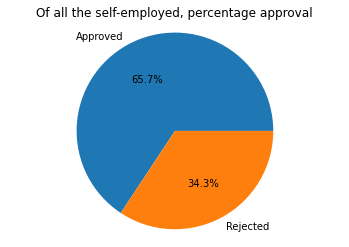

In [193]:

plt.pie(self_emp['count'], labels=self_emp['Status'], autopct='%1.1f%%')
plt.title('Of all the self-employed, percentage approval')
plt.axis('equal')
plt.show();

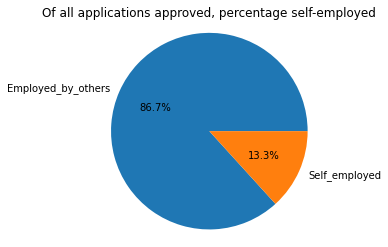

In [187]:

plt.pie(self_emp2['count'], labels=self_emp2['employed_type'], autopct='%1.1f%%')
plt.title('Of all applications approved, percentage self-employed')
plt.axis('equal')
plt.show();



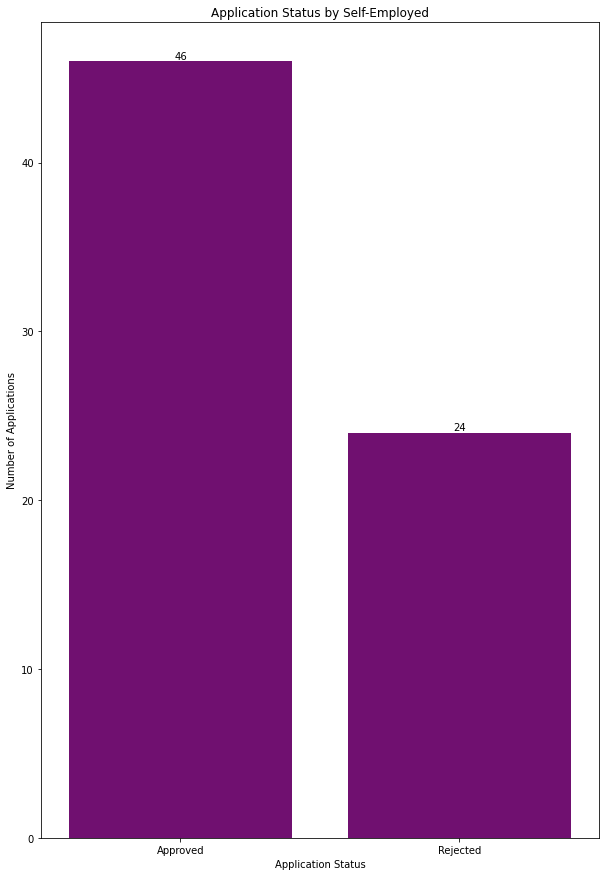

In [196]:
fig, ax = plt.subplots(figsize=(10, 15))
ax = sns.barplot(x='Status', y='count', data=self_emp, color='purple')
plt.title('Application Status by Self-Employed')
plt.xlabel('Application Status')
plt.ylabel('Number of Applications')
ax.bar_label(ax.containers[0]);

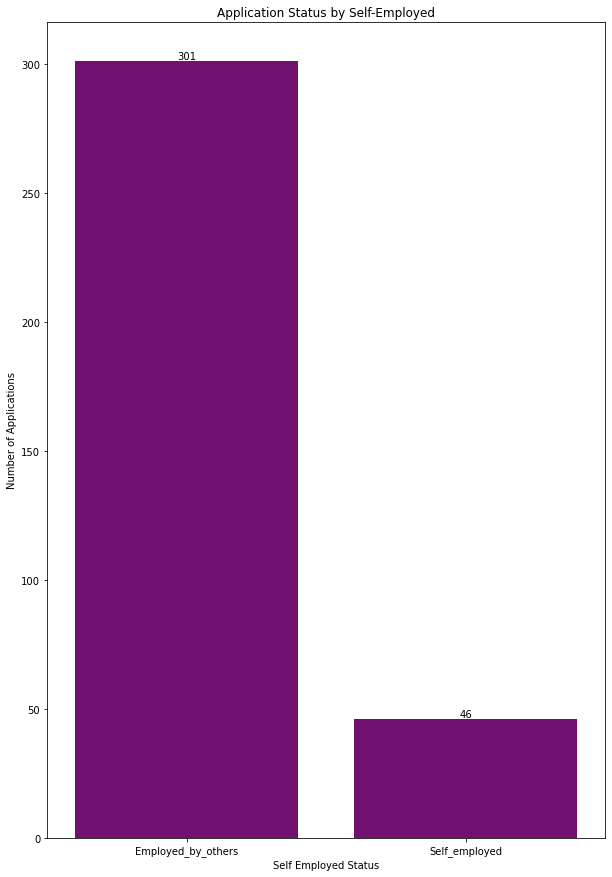

In [198]:
fig, ax = plt.subplots(figsize=(10, 15))
ax = sns.barplot(x='employed_type', y='count', data=self_emp2, color='purple')
plt.title('Application Status by Self-Employed')
plt.xlabel('Self Employed Status')
plt.ylabel('Number of Applications')
ax.bar_label(ax.containers[0]);

In [203]:
fig_checking2 = pd_loan.groupby(['Gender', 'Married', 'Application_Status'])['Application_Status'].count()
fig_checking2

Gender  Married  Application_Status
Female  No       Approved               40
                 Rejected               26
        Yes      Approved               17
                 Rejected                8
Male    No       Approved               71
                 Rejected               43
        Yes      Approved              219
                 Rejected               87
Name: Application_Status, dtype: int64

In [202]:
pd_married_male = pd_loan.loc[(pd_loan.Gender == 'Male') & (pd_loan.Married == 'Yes')]
pd_married_men = pd_married_male.groupby(['Application_Status'])['Application_Status'].count()
pd_married_men


Application_Status
Approved    219
Rejected     87
Name: Application_Status, dtype: int64

In [204]:
app_status_married_men = pd_married_male.Application_Status.value_counts()
married_men = app_status_married_men.reset_index()
married_men.columns = ['Status', 'count']

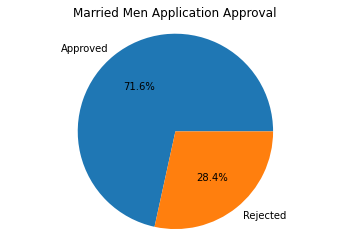

In [205]:
plt.pie(married_men['count'], labels=married_men['Status'], autopct='%1.1f%%')
plt.title('Married Men Application Approval')
plt.axis('equal')
plt.show();

In [207]:
pd_credit.columns

Index(['BRANCH_CODE', 'CUST_CC_NO', 'CUST_SSN', 'DAY', 'MONTH',
       'TRANSACTION_ID', 'TRANSACTION_TYPE', 'TRANSACTION_VALUE', 'YEAR',
       'TIMEID'],
      dtype='object')

In [211]:
print(pd_credit.sort_values(by=['TIMEID'], ascending=False).head(2))
print(pd_credit.sort_values(by=['TIMEID'], ascending=True).head(2))

       BRANCH_CODE        CUST_CC_NO   CUST_SSN  DAY  MONTH  TRANSACTION_ID  \
13787           43  4210653317392678  123457286   28     12           13788   
7422            75  4210653388841064  123458478   28     12            7423   

      TRANSACTION_TYPE  TRANSACTION_VALUE  YEAR      TIMEID  
13787        Education              87.58  2018  2018-12-28  
7422             Bills              86.33  2018  2018-12-28  
       BRANCH_CODE        CUST_CC_NO   CUST_SSN  DAY  MONTH  TRANSACTION_ID  \
33193          123  4210653362839417  123453697    1      1           33194   
43679           15  4210653368958546  123451540    1      1           43680   

      TRANSACTION_TYPE  TRANSACTION_VALUE  YEAR      TIMEID  
33193       Healthcare              23.30  2018  2018-01-01  
43679              Gas              18.18  2018  2018-01-01  


In [217]:
monthly_transactions = pd_credit.groupby(['MONTH'])['TRANSACTION_VALUE'].sum()
monthly_transactions

MONTH
1     196568.87
2     201086.67
3     196488.59
4     194203.25
5     201310.26
6     195468.74
7     201199.35
8     196453.41
9     196069.44
10    202583.89
11    200549.36
12    201251.08
Name: TRANSACTION_VALUE, dtype: float64

In [239]:
month_count = monthly_transactions.reset_index()
month_count.columns = ['month', 'total_transactions']
month_count

,month,total_transactions
0,1,196568.87
1,2,201086.67
2,3,196488.59
3,4,194203.25
4,5,201310.26
5,6,195468.74
6,7,201199.35
7,8,196453.41
8,9,196069.44
9,10,202583.89


In [240]:
month_count.dtypes

month                   int64
total_transactions    float64
dtype: object

In [241]:
month_count['month'] = month_count['month'].apply(str)
month_count['month'] = month_count['month'].replace(['1','2','3','4','5','6','7','8','9','10','11','12'], 
                          ['Jan','Feb','Mar','Apr','May','Jun','Jul','Aug','Sept','Oct','Nov','Dec'])
#month_count.loc[:,'total_transactions'] ='$'+ month_count['total_transactions'].map('{:,.0f}'.format)
month_count

,month,total_transactions
0,Jan,196568.87
1,Feb,201086.67
2,Mar,196488.59
3,Apr,194203.25
4,May,201310.26
5,Jun,195468.74
6,Jul,201199.35
7,Aug,196453.41
8,Sept,196069.44
9,Oct,202583.89


In [242]:
top_3_months = month_count.sort_values(by=['total_transactions'], ascending=False).head(3)
top_3_months

,month,total_transactions
9,Oct,202583.89
4,May,201310.26
11,Dec,201251.08


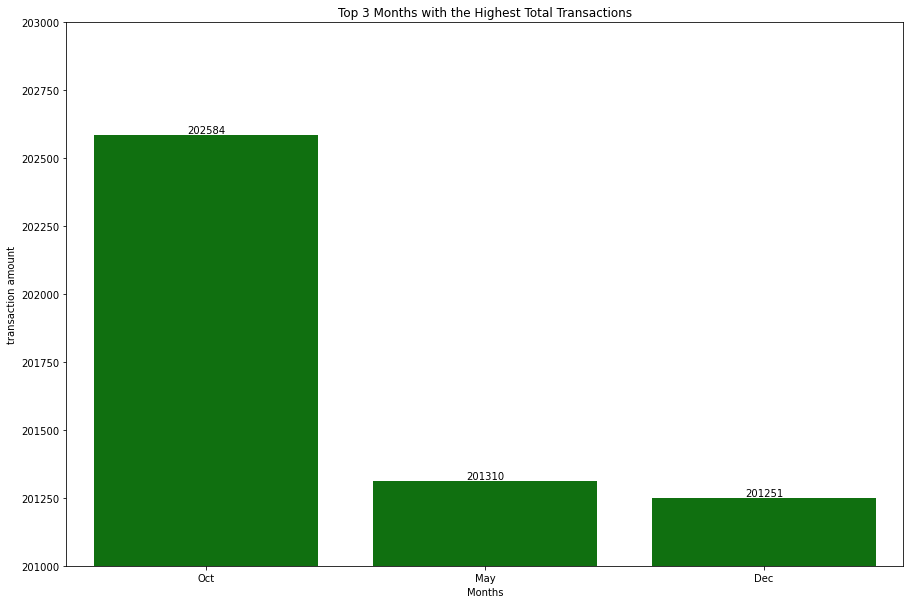

In [243]:
fig, ax = plt.subplots(figsize=(15, 10))
ax = sns.barplot(x='month', y='total_transactions', data=top_3_months, color='green')
plt.title('Top 3 Months with the Highest Total Transactions')
plt.xlabel('Months')
plt.ylabel('transaction amount')
plt.ylim(201000, 203000)
ax.bar_label(ax.containers[0]);

Find and plot which branch processed the highest total dollar value of healthcare transactions.

In [251]:
pd_credit.head(5)

,BRANCH_CODE,CUST_CC_NO,CUST_SSN,DAY,MONTH,TRANSACTION_ID,TRANSACTION_TYPE,TRANSACTION_VALUE,YEAR,TIMEID
0,114,4210653349028689,123459988,14,2,1,Education,78.90,2018,2018-02-14
1,35,4210653349028689,123459988,20,3,2,Entertainment,14.24,2018,2018-03-20
2,160,4210653349028689,123459988,8,7,3,Grocery,56.70,2018,2018-07-08
3,114,4210653349028689,123459988,19,4,4,Entertainment,59.73,2018,2018-04-19
4,93,4210653349028689,123459988,10,10,5,Gas,3.59,2018,2018-10-10


In [259]:
pd_credit.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 46694 entries, 0 to 46693
Data columns (total 10 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   BRANCH_CODE        46694 non-null  int64  
 1   CUST_CC_NO         46694 non-null  object 
 2   CUST_SSN           46694 non-null  int64  
 3   DAY                46694 non-null  int64  
 4   MONTH              46694 non-null  int64  
 5   TRANSACTION_ID     46694 non-null  int64  
 6   TRANSACTION_TYPE   46694 non-null  object 
 7   TRANSACTION_VALUE  46694 non-null  float64
 8   YEAR               46694 non-null  int64  
 9   TIMEID             46694 non-null  object 
dtypes: float64(1), int64(6), object(3)
memory usage: 3.6+ MB


In [247]:
pd_branch = df_branch.toPandas()
pd_branch.head()

,BRANCH_CITY,BRANCH_CODE,BRANCH_NAME,BRANCH_PHONE,BRANCH_STATE,BRANCH_STREET,BRANCH_ZIP,LAST_UPDATED
0,Lakeville,1,Example Bank,(123)456-5276,MN,Bridle Court,55044,2018-04-18T16:51:47.000-04:00
1,Huntley,2,Example Bank,(123)461-8993,IL,Washington Street,60142,2018-04-18T16:51:47.000-04:00
2,SouthRichmondHill,3,Example Bank,(123)498-5926,NY,Warren Street,11419,2018-04-18T16:51:47.000-04:00
3,Middleburg,4,Example Bank,(123)466-3064,FL,Cleveland Street,32068,2018-04-18T16:51:47.000-04:00
4,KingOfPrussia,5,Example Bank,(123)484-9701,PA,14th Street,19406,2018-04-18T16:51:47.000-04:00


In [252]:
healthcare_trans_pd = pd_credit.loc[(pd_credit.TRANSACTION_TYPE == 'Healthcare')]
healthcare_by_branch = healthcare_trans_pd.groupby(['BRANCH_CODE'])['TRANSACTION_VALUE'].sum()
healthcare_by_branch

BRANCH_CODE
1      2920.15
2      3284.31
3      3353.55
4      2436.80
5      2736.69
        ...   
175    3341.57
178    2957.41
180    2344.08
188    2869.18
192    1960.35
Name: TRANSACTION_VALUE, Length: 114, dtype: float64

In [253]:
healthcare_total_df = healthcare_by_branch.reset_index()
healthcare_total_df

,BRANCH_CODE,TRANSACTION_VALUE
0,1,2920.15
1,2,3284.31
2,3,3353.55
3,4,2436.80
4,5,2736.69
...,...,...
109,175,3341.57
110,178,2957.41
111,180,2344.08
112,188,2869.18


In [256]:
healthcare_tran_allcolumns_df = pd.merge(healthcare_total_df, pd_branch, on ='BRANCH_CODE')
healthcare_tran_allcolumns_df.head(5)

,BRANCH_CODE,TRANSACTION_VALUE,BRANCH_CITY,BRANCH_NAME,BRANCH_PHONE,BRANCH_STATE,BRANCH_STREET,BRANCH_ZIP,LAST_UPDATED
0,1,2920.15,Lakeville,Example Bank,(123)456-5276,MN,Bridle Court,55044,2018-04-18T16:51:47.000-04:00
1,2,3284.31,Huntley,Example Bank,(123)461-8993,IL,Washington Street,60142,2018-04-18T16:51:47.000-04:00
2,3,3353.55,SouthRichmondHill,Example Bank,(123)498-5926,NY,Warren Street,11419,2018-04-18T16:51:47.000-04:00
3,4,2436.80,Middleburg,Example Bank,(123)466-3064,FL,Cleveland Street,32068,2018-04-18T16:51:47.000-04:00
4,5,2736.69,KingOfPrussia,Example Bank,(123)484-9701,PA,14th Street,19406,2018-04-18T16:51:47.000-04:00


In [258]:
healthcare_tran_df = healthcare_tran_allcolumns_df[['BRANCH_CODE', 'TRANSACTION_VALUE', 'BRANCH_NAME']].copy()
healthcare_tran_df

,BRANCH_CODE,TRANSACTION_VALUE,BRANCH_NAME
0,1,2920.15,Example Bank
1,2,3284.31,Example Bank
2,3,3353.55,Example Bank
3,4,2436.80,Example Bank
4,5,2736.69,Example Bank
...,...,...,...
109,175,3341.57,Example Bank
110,178,2957.41,Example Bank
111,180,2344.08,Example Bank
112,188,2869.18,Example Bank


In [260]:
pd_branch['BRANCH_NAME'].value_counts()

Example Bank    115
Name: BRANCH_NAME, dtype: int64

In [265]:
top_branch_for_healthcare_trans = healthcare_total_df.sort_values(by=['TRANSACTION_VALUE'], ascending=False).head(1)
top_branch_for_healthcare_trans

,BRANCH_CODE,TRANSACTION_VALUE
22,25,4370.18


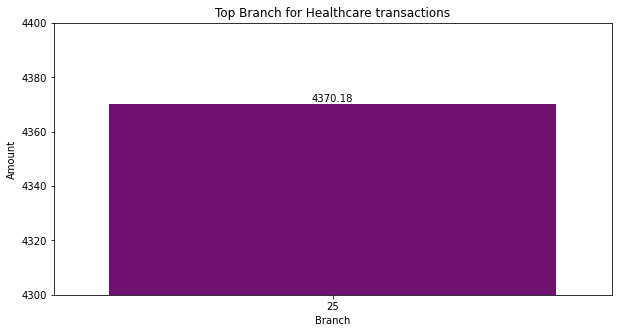

In [266]:
fig, ax = plt.subplots(figsize=(10, 5))
ax = sns.barplot(x='BRANCH_CODE', y='TRANSACTION_VALUE', data=top_branch_for_healthcare_trans, color='purple')
plt.title('Top Branch for Healthcare transactions')
plt.xlabel('Branch')
plt.ylabel('Amount')
plt.ylim(4300, 4400)
ax.bar_label(ax.containers[0]);

Find and plot the percentage of applications approved for self-employed applicants.
Note: Take a screenshot of the graph. 
Find the percentage of rejection for married male applicants.
Note: Take a screenshot of the graph.
Find and plot the top three months with the largest transaction data.
Note: Take a screenshot of the graph. 
Find and plot which branch processed the highest total dollar value of healthcare transactions.
Note: Take a screenshot of the graph. 

